In [1]:
import requests
from bs4 import BeautifulSoup
import re
import time
import numpy as np
import pandas as pd
import pickle
import os

In [2]:
os.chdir('Data2/')

In [3]:
style_nums = os.listdir()

In [4]:
df = pd.DataFrame(columns = ['beer_name','brewery_name','abv',
                             'ratings','score','brewery_nums'])

for num in style_nums:
    pickled = pd.read_pickle(num)
    df = pd.concat([df,pickled],sort=True)

In [5]:
df.head()

,abv,beer_name,brewery_name,brewery_nums,ratings,score,style
0,7.50,Guinness Foreign Extra Stout,Guinness Ltd.,209,"2,468",4.06,Foreign / Export Stout
1,8.80,Lion Stout,Ceylon / Lion Brewery Limited,389,"1,655",3.91,Foreign / Export Stout
2,7.00,Indra Kunindra,Ballast Point Brewing Company,199,"1,285",3.67,Foreign / Export Stout
3,8.50,Fade To Black - Volume 1,Left Hand Brewing Company,418,"1,023",4.08,Foreign / Export Stout
4,6.30,Best Extra Stout,Coopers Brewery Limited,491,691,3.84,Foreign / Export Stout


In [6]:
brewery_nums = df['brewery_nums'].unique()

In [65]:
def get_brewery_info(brew_nums):
    
    dic = {}
    
    for brew_num in brew_nums:
        url = 'https://www.beeradvocate.com/beer/profile/' + str(brew_num) + '/'
    
        # Getting soup

        key = []
        values = []
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page, "lxml")

        # Finding feature values

        try:
            title_div = soup.find(class_='titleBar')
            brew_name = str(title_div.text).replace('\n','')
        except:
            brew_name = 'NA'

        try:
            score_obj = soup.find('span', {'class': 'BAscore_big'})
            score = re.split(r'>|<', str(score_obj))[4]
        except:
            score = 'NA'

        try:   
            beer_class_obj = soup.find_all('b')[4]
            beer_class = re.split(r'>|<', str(beer_class_obj))[2]
        except:
            beer_class = 'NA'

        try:
            stats_objs = soup.find_all('dd')[5:13]
            stats_list = []
            for item in stats_objs:
                item = str(item.text).strip()
                if len(item) > 0:
                    clean_item = re.sub(r'#|%|,|/5','',item)
                    if '.' in clean_item:
                        stats_list.append(clean_item)
                    else:
                        stats_list.append(clean_item)
                else:
                    pass
            num_beers, num_beer_reviews, num_beer_ratings, brew_score, reviews, ratings, pDev = stats_list
        except:
            try:
                num_beers = soup.find_all('dd')[5].text
            except:
                num_beers = np.nan
            try:
                num_beer_reviews = soup.find_all('dd')[6].text
            except:
                num_beer_reviews = np.nan
            try:
                num_beer_ratings = soup.find_all('dd')[7].text
            except:
                num_beer_ratings = np.nan
            
            stats_list = ('NA '*4).split()

            brew_score, reviews, ratings, pDev = stats_list

        # Lots of data floats freely within info_box

        info_box = soup.find('div',attrs={'id':'info_box'})

        try:
            town = soup.select("a[href*=/place/list]")[0].text
        except:
            town = 'NA'
        
        try:
            state_region_str = str(info_box).split('/">')[1]
            state_region = state_region_str.split('</a')[0]
        except:
            state_region = 'NA'
        
        try:
            country_str = str(info_box).split('/">')[-1]
            country = country_str.split('</a')[0]
        except:
            country = 'NA'
        
        try:
            b_type = re.split(r'INFO</b>\n<br/><br/>\n<b>Type:</b> |\n<br/><br/>\n',
                     str(info_box),maxsplit=4)[1]
        except:
            b_type = 'NA'

        try:
            phone_string = re.split(r'</a><br/><br/>',
                                    str(info_box),maxsplit=4)
            phone_num_string = phone_string[1].split(' |')[0]
            phone_num = re.sub(r'\(|\)| |-','',phone_num_string)
            int(phone_num)
            has_phone = True
        except:
            has_phone = False

        try:   
            comm_desc_str = str(info_box).split('Notes:</b>\n<br/>\n')[1]
            comm_desc = comm_desc_str.split('<br')[0]
        except:
            comm_desc = 'NA'        

        key = brew_name

        values = [score, beer_class, num_beers, town, state_region, country,
                  num_beer_reviews, num_beer_ratings, brew_score, 
                  reviews, ratings, pDev, b_type, has_phone, comm_desc]
        
        dic[key] = values
    
        time.sleep(np.random.poisson(10)/100)
    
    try:
        df = pd.DataFrame(dic)     
        df = df.transpose()      
        pd.DataFrame.to_pickle(df,'breweries_with_loc')
    except:
        pass
    
    return dic

In [66]:
%%time
dic = get_brewery_info(brewery_nums)

CPU times: user 17min 26s, sys: 23.2 s, total: 17min 49s
Wall time: 1h 43min 43s


In [26]:
brews = pd.read_pickle('breweries')

In [27]:
brews.head()

,0,1,2,3,4,5,6,7,8,9,10,11
Guinness Ltd.,3.45,Okay,48,8736,29517,3.92,2,6,5.61,"Brewery, Bar, Eatery, Beer-to-go",False,No notes at this time.
Ceylon / Lion Brewery Limited,3.11,Okay,6,"1,145","2,014",NA,NA,NA,NA,Brewery,True,No notes at this time.
Ballast Point Brewing Company,3.91,Very Good,175,14500,66985,4.34,70,405,11.75,"Brewery, Bar",True,Acquired by Constellation Brands in 2015
Left Hand Brewing Company,3.78,Very Good,70,7747,26496,4.25,47,179,12.71,"Brewery, Bar, Beer-to-go",True,No notes at this time.
Coopers Brewery Limited,2.99,Poor,16,"1,638","2,776",NA,NA,NA,NA,Brewery,True,No notes at this time.


In [67]:
df = pd.read_pickle('breweries_with_loc')

In [68]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Guinness Ltd.,3.45,Okay,48,Dublin,Ireland,Ireland,8736,29518,3.92,2,6,5.61,"Brewery, Bar, Eatery, Beer-to-go",False,No notes at this time.
Ceylon / Lion Brewery Limited,3.11,Okay,6,Biyagama,Sri Lanka,Sri Lanka,"1,145","2,014",NA,NA,NA,NA,Brewery,True,No notes at this time.
Ballast Point Brewing Company,3.91,Very Good,175,San Diego,California,United States,14500,66988,4.34,70,405,11.75,"Brewery, Bar",True,Acquired by Constellation Brands in 2015
Left Hand Brewing Company,3.78,Very Good,70,Longmont,Colorado,United States,7749,26500,4.25,47,179,12.71,"Brewery, Bar, Beer-to-go",True,No notes at this time.
Coopers Brewery Limited,2.99,Poor,16,Leabrook,Australia,Australia,"1,638","2,776",NA,NA,NA,NA,Brewery,True,No notes at this time.


In [69]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,14979,14979,14979,14979,14979,14979,14979,14979,14979,14979,14979,14979,14979,14979,14979
unique,338,10,216,7559,258,195,986,1594,262,129,253,1649,17,2,1407
top,0,Good,1,Portland,Germany,United States,0,1,NA,NA,NA,NA,Brewery,True,No notes at this time.
freq,890,4211,1795,95,930,6857,3027,1478,6349,6349,6349,6349,6345,13116,13389


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14979 entries, Guinness Ltd. to The Order of Yoni
Data columns (total 15 columns):
0     14979 non-null object
1     14979 non-null object
2     14979 non-null object
3     14979 non-null object
4     14979 non-null object
5     14979 non-null object
6     14979 non-null object
7     14979 non-null object
8     14979 non-null object
9     14979 non-null object
10    14979 non-null object
11    14979 non-null object
12    14979 non-null object
13    14979 non-null object
14    14979 non-null object
dtypes: object(15)
memory usage: 1.8+ MB


In [80]:
df[0] = df[0].apply(float)

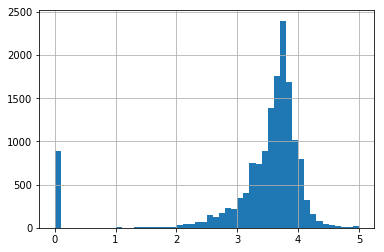

In [85]:
df[0].hist(bins=50)